In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
Bpossible = np.linspace(2,70,3)
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=2)
Y = Yall[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,mV = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded data data/guo_ssData.p with nrowsXncols = (437, 2).
(437, 2)
(437,)
LoadMouseQPCRData output
(219, 2)
(219,)
Y
(219, 1)
Branching kernel =====================
unnamed.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.Bv transform:(none) prior:None [FIXED]
[[ 1.]]
unnamed.white.variance transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================

model.kern.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.Bv transform:(none) prior:None [FIXED]
[[ 1.]]
model.kern.white.variance transform:+ve prior:None
[ 1.]
model.likelihood.variance transform:+ve prior:None
[ 1.]
Initialise models: VB =====================
compiling tensorflow function...
done


In [4]:
Bpossible=None
strSaveState='test'
fSoftVBAssignment=False
fOptimizeHyperparameters = False
fReestimateMAPZ=False
numMAPsteps = 10
D=Y.shape[1]
print D

1


In [5]:
# Do the MAP solution and plot assignments
Kbranch = m.kern
pt = mV.t
b = 20

Bcrap = np.atleast_2d(b) # crappy branch point

# reinitialise hyperparameters
Kbranch.white.variance = 1e-6
Kbranch.branchkernelparam.kern.lengthscales = 100 # 20 + (90. - b) / 2. # 65
Kbranch.branchkernelparam.kern.variance = 2 #0.0012 #  2.3158
m.likelihood.variance = 0.08
mV.likelihood.variance = m.likelihood.variance._array

# should recompute Kernel everytime we update kernel hyperparameters
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

# set branching point
m.kern.branchkernelparam.Bv = Bcrap 

print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())

# Random assignment for given branch point

np.random.seed(47)

randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
print 'MAP assignment.'
(chainState, bestAssignment,_,condProbs) = \
    m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
    maximumNumberOfSteps=numMAPsteps,\
    startingAssignment=list(randomAssignment))
    
    
    

============> B=[ 20.]
MAP assignment.
Performing MAP inference with B=[ 20.]
Converged after 2 iterations, lik=11.884


In [6]:
m

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,[FIXED]
model.kern.white.variance,[ 1.00000000e-06],None,+ve
model.likelihood.variance,[ 0.08],None,+ve


In [7]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,[FIXED]
model.kern.white.variance,[ 1.00000000e-06],None,+ve
model.likelihood.variance,[ 0.08],None,+ve
model.logPhi,"[[ 0.08885009 2.14467941 0.77814557 ..., 0.4578781 -0.39441331 0.18146189] [-0.41996604 1.57179177 0.26513827 ..., -1.81504796 0.24772394 -1.58377491] [-0.07445249 -0.29603081 1.47733675 ..., 1.66252864 0.24228797 0.7833095 ] ..., [ 1.24712585 0.66052001 1.26377976 ..., -0.03783879 -1.06446528 -0.58209469] [-2.09595086 -0.13147371 -0.10528101 ..., 0.8234488 -1.41092942 0.43896945] [ 0.2965691 -0.78068456 -0.5793271 ..., 0.90284255 2.30573444 0.55998588]]",None,(none)


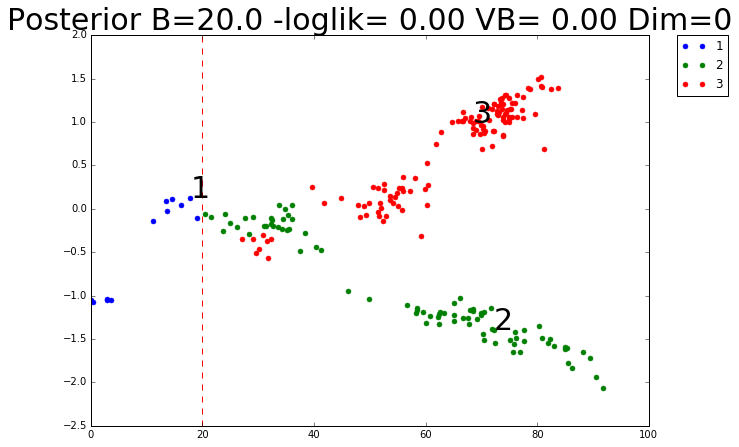

In [8]:
# Plot MAP solution
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

Variational kernel branch value [ 22.]
InitialisePhi:Warning switching to square transform
compiling tensorflow function...
done
optimization terminated, setting model state
B=22.0. VB bound=49.09.
Variational kernel branch value [ 29.55555556]
InitialisePhi:Warning switching to square transform
compiling tensorflow function...
done
optimization terminated, setting model state
B=29.5555555556. VB bound=46.10.
Variational kernel branch value [ 37.11111111]
InitialisePhi:Warning switching to square transform
compiling tensorflow function...
done
optimization terminated, setting model state
B=37.1111111111. VB bound=45.97.
Variational kernel branch value [ 44.66666667]
InitialisePhi:Warning switching to square transform
compiling tensorflow function...
done
optimization terminated, setting model state
B=44.6666666667. VB bound=60.31.
Variational kernel branch value [ 52.22222222]
InitialisePhi:Warning switching to square transform
compiling tensorflow function...
done
optimization termina

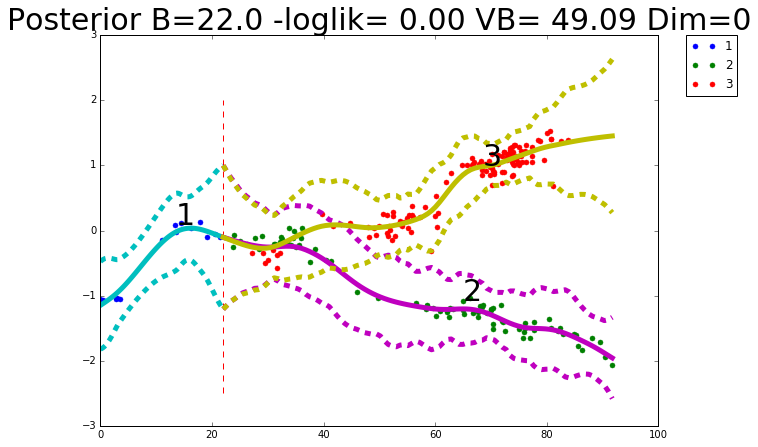

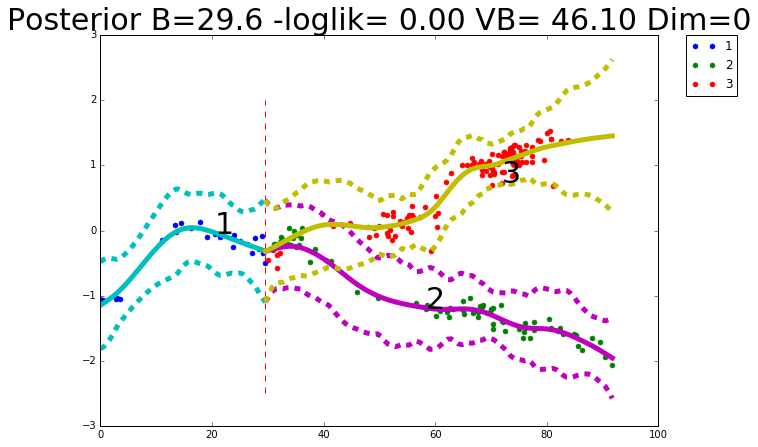

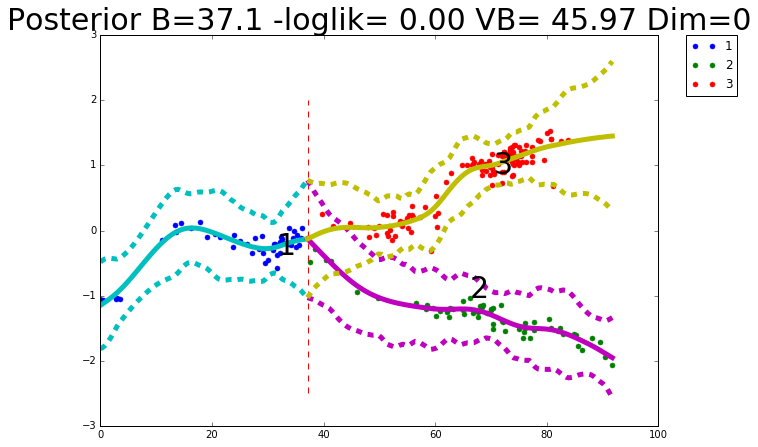

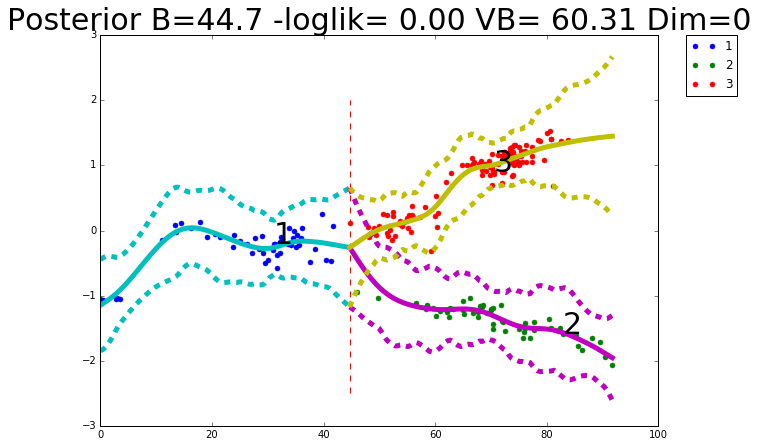

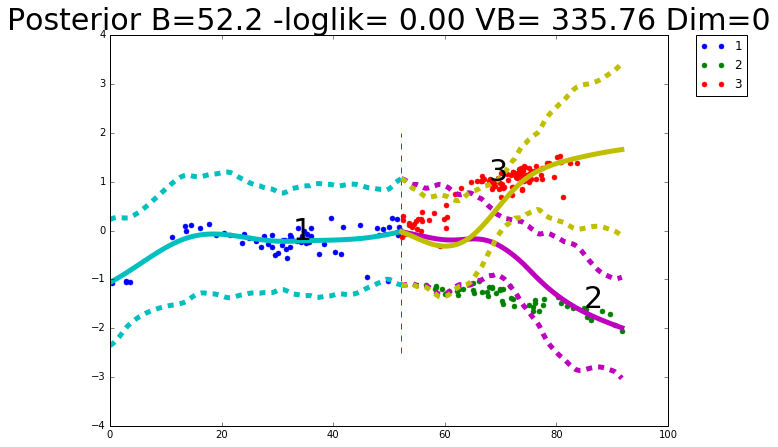

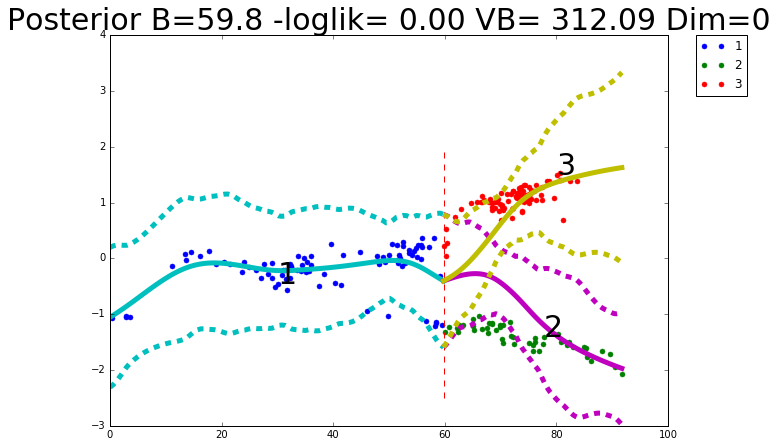

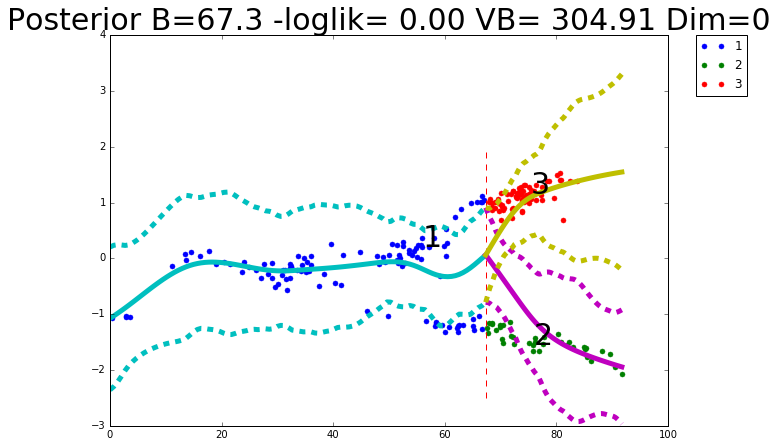

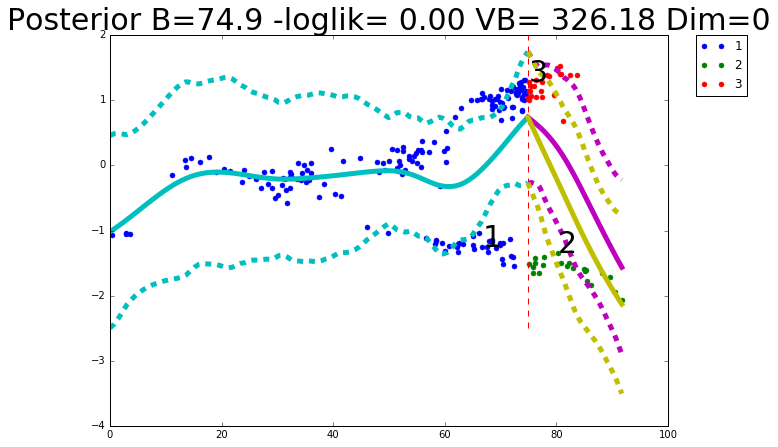

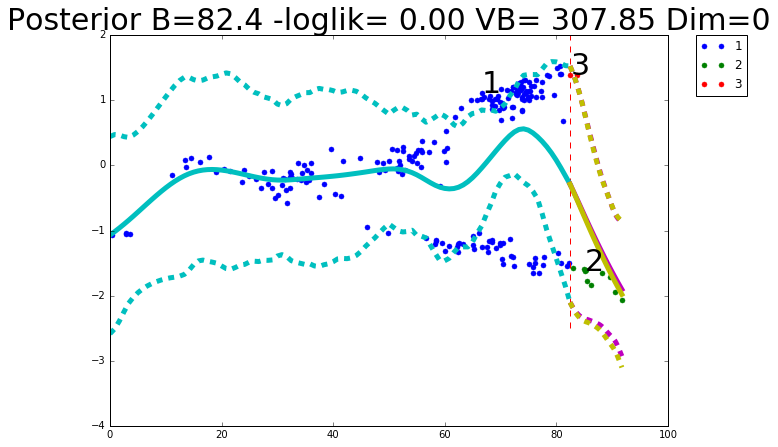

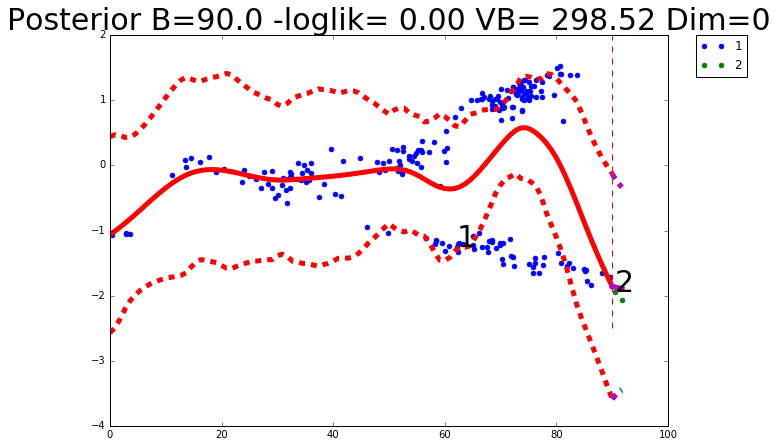

In [9]:
Bpossible = np.linspace(22,90,10)
logVBBound = []

Kbranch = m.kern
pt = mV.t

mV.kern.branchkernelparam.Bv.fixed = True # B not part of the state

stateSaved = mV.get_free_state().copy()

for ib,b in enumerate(Bpossible):
    
    mV.set_state(stateSaved)
    
    Bcrap = np.atleast_2d(b) # crappy branch point - remove?

    # reset branching allocations for before branching point
    bestAssignmentCensored = list(bestAssignment)
    for i,bi in enumerate(bestAssignment):
        if mV.X[bi,0] < b :
            # before branching point 
            bestAssignmentCensored[i] = m.indices[i][0]
        
    # Variational bound computation
    mV.kern.branchkernelparam.Bv = Bcrap
    mV._needs_recompile = True
    
    print 'Variational kernel branch value ' + str(mV.kern.branchkernelparam.Bv._array.flatten())
    # Set state for assignments
    
    fSoft = True
    if(fSoft):
        mV.InitialisePhi(m.indices, bestAssignmentCensored, b, condProbs, fSoftAssignment = True, fSoftUni = False)
    else:
        N = Y.shape[0]
        phiInitial = np.zeros((N, 3*N))
        phiInitial_invSoftmax = np.zeros((N, 3*N))  # large neg number makes exact zeros, make smaller for added jitter
        for i, n in enumerate(bestAssignmentCensored):
            phiInitial[i, n] = 1
            phiInitial_invSoftmax[i, n] = 10
        mV.logPhi = phiInitial_invSoftmax

    mV.optimize(max_iters=25)
    
    VBbound = -mV.compute_log_likelihood()
    logVBBound.append(VBbound)

    assigngp_dense.PlotSample(D, mV.X[bestAssignmentCensored, : ],3,Y,Bcrap,lw=5.,fs=30, \
                          mV=mV, figsizeIn=(D*10,D*7), title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,VBbound))



    print 'B=' + str(b) + '. VB bound=%.2f.'%(VBbound)    

VB estimated B 37.1111111111 with marginal likelihood [ 45.97170253]


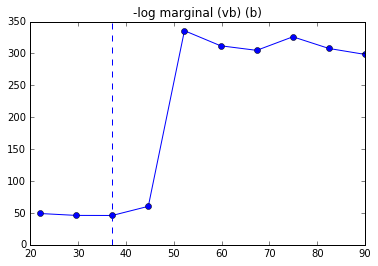

In [10]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logVBBound)],nlogL, '-ob')
plt.title('-log marginal (vb) (b)')

v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')

print 'VB estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])

In [11]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 38.60946394],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 75.25890915],None,+ve
model.kern.branchkernelparam.Bv,[[ 90.]],None,[FIXED]
model.kern.white.variance,[ 9.99349288e-07],None,+ve
model.likelihood.variance,[ 0.75475955],None,+ve
model.logPhi,"[[ 6.79636086 -9.00991027 -9.00996082 ..., -9.00956475 -9.0084258 -9.00847512] [-9.00794023 -9.00996895 -9.01002043 ..., -9.00963242 -9.00847087 -9.00852118] [-9.00791851 -9.00991585 -9.00996626 ..., -9.009568 -9.00843278 -9.00848192] ..., [-9.01035554 -9.00960684 -9.00955596 ..., -9.00787739 -9.00933728 -9.00926679] [-9.01043256 -9.00962052 -9.00956717 ..., -9.00785689 -9.0093789 -9.0093055 ] [-9.01043647 -9.00964226 -9.0095895 ..., 6.94309875 -9.0093926 -9.00931987]]",None,(none)
